# EDA

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook

In [2]:
raw_data = "../raw/train.csv"
sub_data = "../raw/sample_submission.csv"
test_data = "../raw/test/{}.csv" 
proc_data = "../processed/{}"

In [76]:
df = pd.read_csv(raw_data, header=0, nrows=5656574)
df.columns = ["x", "y"]

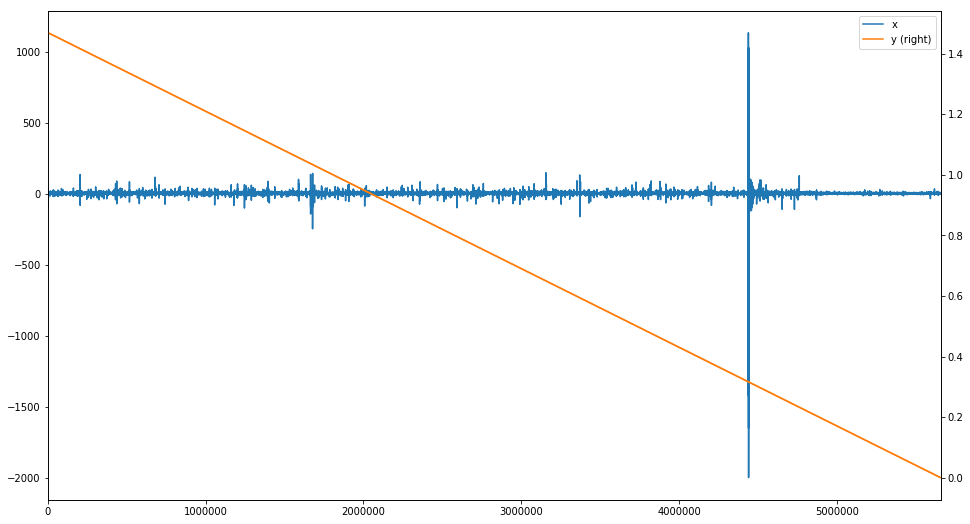

In [4]:
df.loc[::100,:].plot(figsize=(16,9), secondary_y=["y"])

In [81]:
df.loc[num * block: (num + 1) * block].x.value_counts().sort_index()

-134    1
-129    1
-127    1
-117    1
-104    1
-91     1
-90     1
-89     1
-87     1
-86     1
-85     2
-83     1
-82     2
-81     1
-78     2
-77     5
-76     2
-75     2
-74     2
-73     1
-72     2
-71     1
-69     2
-68     3
-67     2
-66     2
-64     1
-63     5
-62     2
-60     2
       ..
 68     4
 69     3
 70     3
 71     3
 72     2
 73     2
 74     2
 75     1
 77     3
 78     1
 79     1
 80     2
 81     1
 83     3
 85     1
 86     1
 88     1
 90     1
 94     5
 95     1
 96     2
 97     1
 100    2
 101    1
 103    1
 107    1
 122    1
 127    1
 138    1
 139    1
Name: x, Length: 186, dtype: int64

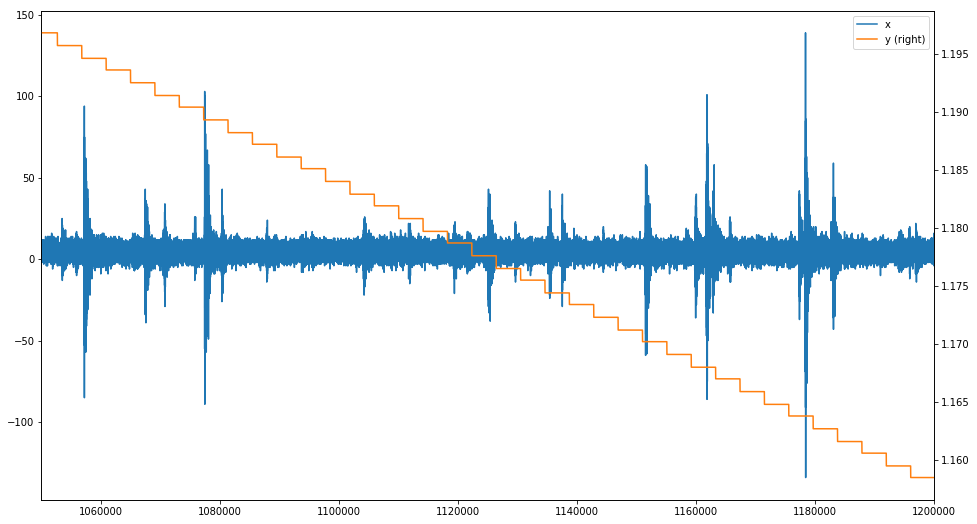

In [78]:
block = 150000
num = 7
df.loc[num * block: (num + 1) * block].plot(figsize=(16,9), secondary_y=["y"])

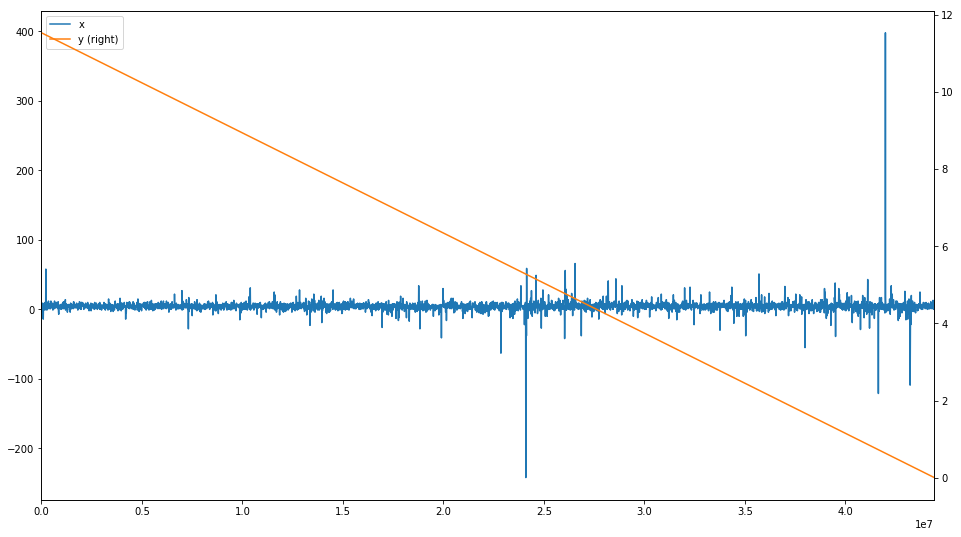

In [6]:
df = pd.read_csv(raw_data, skiprows=5656574, nrows=44429303)
df.columns = ["x", "y"]
df.loc[::10000,:].plot(figsize=(16,9), secondary_y=["y"])

In [7]:
block = 150000
44429303 / block

296.19535333333334

In [59]:
1/ 296

0.0033783783783783786

In [32]:
np.log(block) / np.log(2)

17.194602975157967

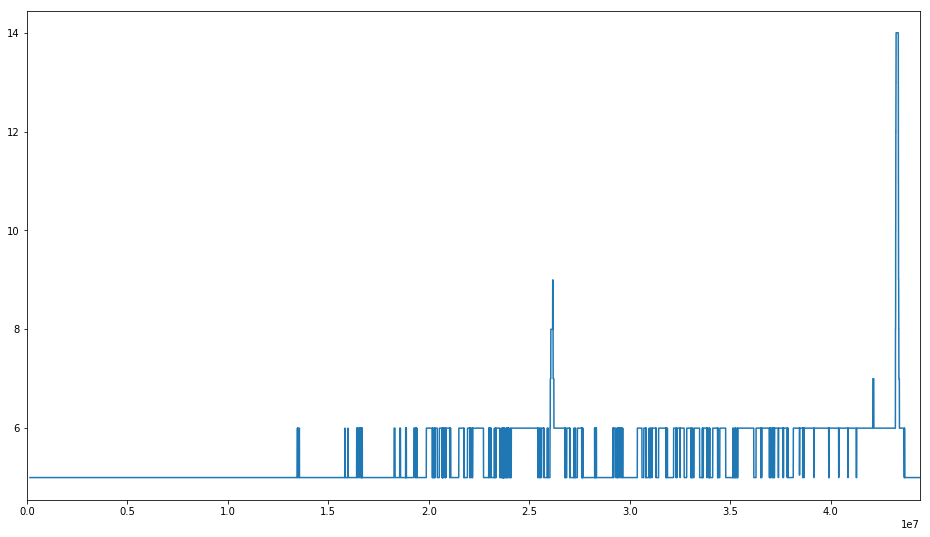

In [75]:
df.x.diff().rolling(block).quantile(0.95).plot(figsize=(16,9))

In [ ]:
roll.plot(figsize=(16,9), ylim=(0, 100))

In [28]:
df.x.mad()

3.4687709051763718

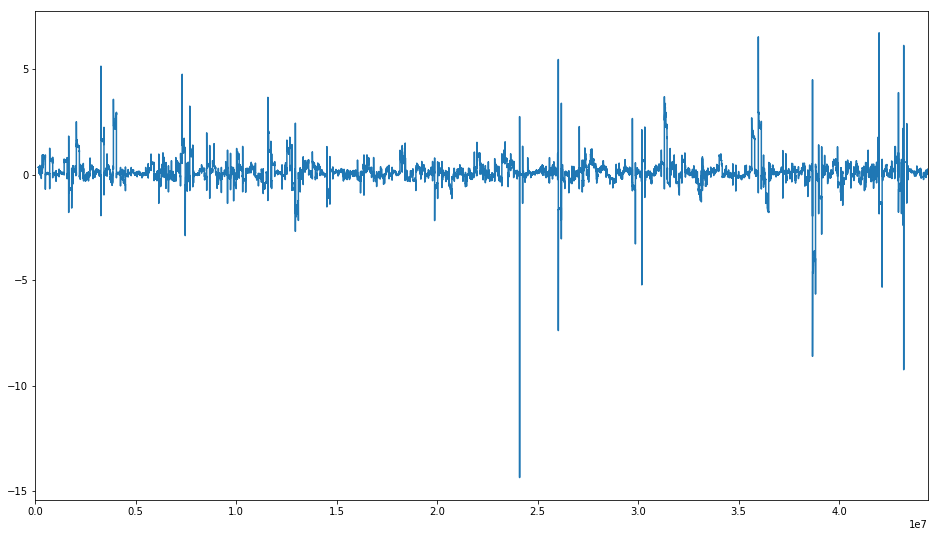

In [80]:
df.x.rolling(block).skew().plot(figsize=(16,9))

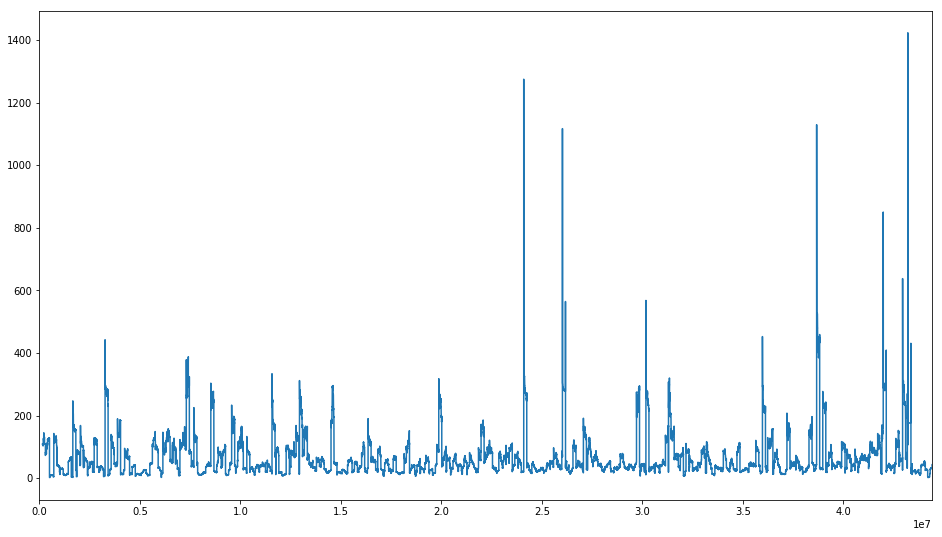

In [79]:
df.x.rolling(block).kurt().plot(figsize=(16,9))

In [38]:
summary = []
for name in tqdm_notebook(pd.read_csv(sub_data).seg_id):
    summary.append(pd.read_csv(test_data.format(name)).describe())

In [39]:
len(summary)

2624

In [40]:
df_sum = pd.concat(summary, axis=1)

In [41]:
df_sum.T.describe()

,count,mean,std,min,25%,50%,75%,max
count,2624.0,2624.000000,2624.000000,2624.000000,2624.000000,2624.000000,2624.000000,2624.000000
mean,150000.0,4.148616,6.684161,-154.099848,1.804402,4.075457,6.488948,165.683689
std,0.0,0.252326,8.744635,291.376009,0.488788,0.280963,0.550770,276.517022
min,150000.0,3.410040,2.848341,-6323.000000,-2.000000,3.000000,5.000000,28.000000
25%,150000.0,3.974123,4.640139,-162.000000,2.000000,4.000000,6.000000,93.000000
50%,150000.0,4.148043,5.816308,-117.000000,2.000000,4.000000,6.000000,128.000000
75%,150000.0,4.328440,7.055588,-81.000000,2.000000,4.000000,7.000000,172.000000
max,150000.0,4.940780,171.321744,-20.000000,3.000000,5.000000,11.000000,6741.000000


In [53]:
def yield_train_blocks(chunksize=150000):
    yield from pd.read_csv(
        raw_data, 
        names=["x", "y"], 
        dtype={"x": "int32", "y": "float32"}, 
        skiprows=1, 
        chunksize=chunksize
    )

In [27]:
def yield_sub_series():
    min_y = None
    blocks = []
    for block in yield_train_blocks():
        blocks.append(block)
        block_min_time = block.y.min()
        if min_y is None or block_min_time < min_y:
            min_y = block_min_time
            continue
        df = pd.concat(blocks, ignore_index=True)
        end_of_series = df.y.idxmin()
        blocks = [df.loc[end_of_series+1:]]
        min_y = blocks[0].y.min()
        yield df.loc[:end_of_series]
    yield pd.concat(blocks, ignore_index=True)

In [28]:
def save_series():
    for num, df in tqdm_notebook(enumerate(yield_sub_series()), total=17):
        df.to_pickle(proc_data.format(f"data{num}.pickle"))

In [29]:
save_series()

In [14]:
q = 0
for df in tqdm_notebook(yield_train_blocks()):
    q += len(df)
print(q)    


629145480


In [52]:
629145480 // 150000 - 17

4177

In [31]:
pd.read_pickle(proc_data.format(f"data7.pickle")).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62009332 entries, 0 to 62009331
Data columns (total 2 columns):
x    int32
y    float32
dtypes: float32(1), int32(1)
memory usage: 473.1 MB


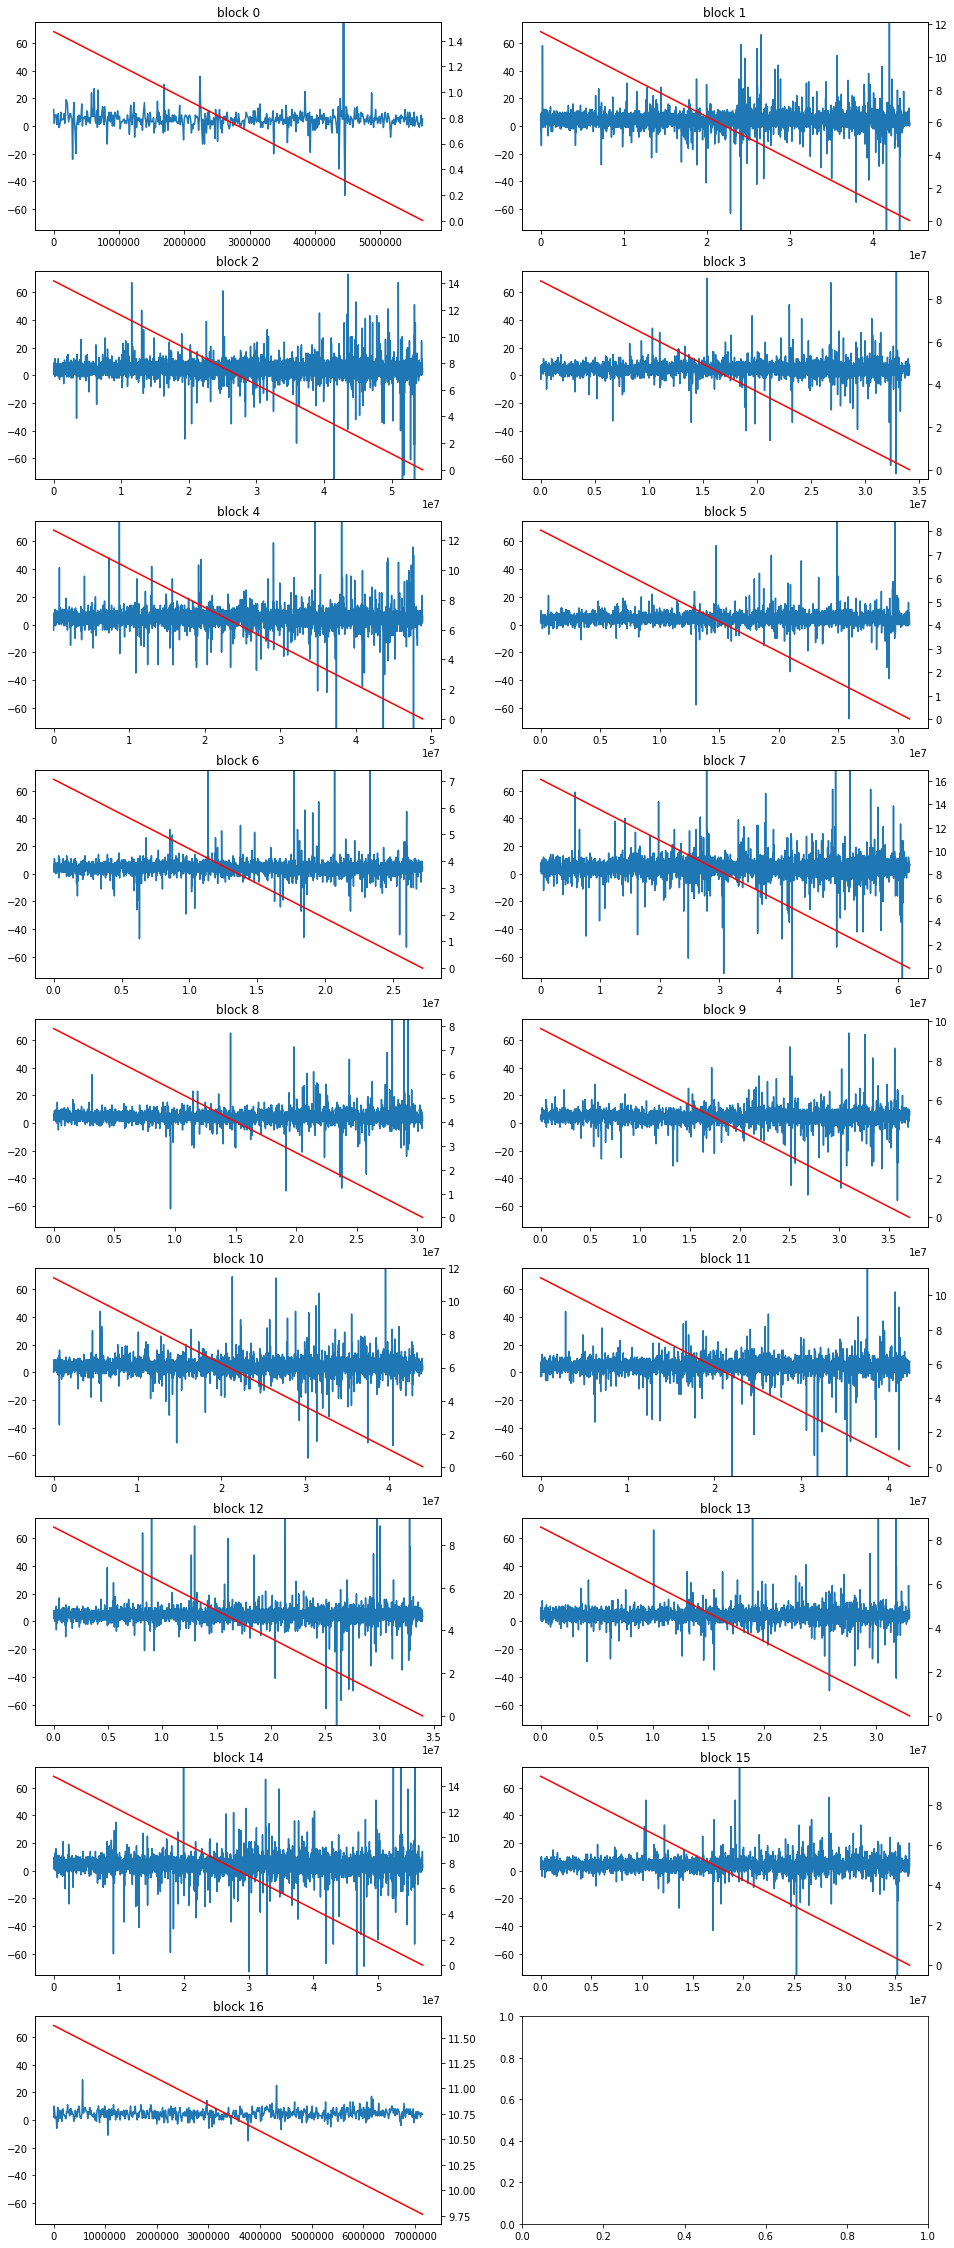

In [50]:
_, axs = plt.subplots(9, 2, figsize=(16, 9 * 9 / 2))
axs = axs.flatten()
for i in tqdm_notebook(range(17)):
    df = pd.read_pickle(proc_data.format(f"data{i}.pickle"))
    axs[i].set_title(f"block {i}") 
    ax2 = axs[i].twinx()
    axs[i].set_ylim(-75, 75)
    axs[i].plot(df.x.loc[::10000])   
    ax2.plot(df.y.loc[::10000], color='r')   

In [44]:
pd.read_csv(proc_data.format("sub_2019-02-05_08-54_passes-30.csv")).time_to_failure.describe()

count    2624.000000
mean        5.012590
std         2.484641
min         0.074535
25%         2.864605
50%         4.420376
75%         7.245340
max        10.178770
Name: time_to_failure, dtype: float64

In [46]:
pd.read_pickle(proc_data.format("train_passes_1.pickle")).y.describe()

count    4178.000000
mean        5.663421
std         3.663446
min         0.006398
25%         2.619046
50%         5.332847
75%         8.147948
max        16.063797
Name: y, dtype: float64

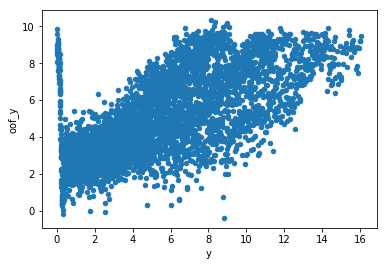

In [63]:
pd.read_pickle(proc_data.format("oof.pickle")).plot.scatter("y", "oof_y")